# Setup

In [1]:
## Setup
from notebook_utils import resolve_paths_from_parent_directory
# auto reload notebook deps
%reload_ext autoreload
%autoreload 2
resolve_paths_from_parent_directory()

# Imports

In [2]:
# imports
import datetime
from experiment_pipeline.data_loader import load_global_feature_set
from experiment_pipeline.feature_sets import baseline_important_features
from run_experiment import run_experiment
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor

# Read Data

In [3]:
data_dir = "../data"
route_str = "B46"
station_str = "JFK"
direction_int = 1


df_route, stop_id_ls = load_global_feature_set(data_dir, route_str, station_str, direction_int)

# Model Training

In [8]:
models = [LassoCV(), RandomForestRegressor(), XGBRegressor()]

for model in models:
    print(model)
    print('\n')
    experiment_eval = run_experiment(
            global_feature_set=df_route,
            feature_extractor_fn=baseline_important_features,
            model=model,
            stop_id_ls=stop_id_ls,
            dependent_variable="passenger_count",
            split_heuristic="datetime",
            test_size=0.1,
            split_datetime=datetime.datetime(year=2021, month=9, day=26, hour=0, minute=0),
            test_period="2D",
            refit_interval=None,
            random_state=0,
            experiment_name=None
        )
    print('\n')
    print("Train")
    model_pred_eval, mean_pred_eval = experiment_eval.regression_metrics("train", pretty_print=True)
    print('\n')
    print('-----------------------------')
    print('\n')
    print("Test")
    model_pred_eval, mean_pred_eval = experiment_eval.regression_metrics("test", pretty_print=True)
    print('\n')
    print('=============================')
    print('\n')

LassoCV()


split: fitting on train data until 2021-09-26 00:00:00: 109,931 rows
split: testing from 2021-09-26 00:00:00 to 2021-09-28 00:00:00: 2,782 rows
Fitting model...
Inference...


Train
Performance: Model Prediction
MAE: 7.1
ME : 74.2
R^2: 0.07


Performance: Mean Prediction
MAE: 7.4
ME : 74.3
R^2: 0.00


-----------------------------


Test
Performance: Model Prediction
MAE: 7.1
ME : 33.1
R^2: -0.04


Performance: Mean Prediction
MAE: 6.8
ME : 38.3
R^2: -0.01




RandomForestRegressor()


split: fitting on train data until 2021-09-26 00:00:00: 109,931 rows
split: testing from 2021-09-26 00:00:00 to 2021-09-28 00:00:00: 2,782 rows
Fitting model...
Inference...


Train
Performance: Model Prediction
MAE: 0.8
ME : 32.9
R^2: 0.99


Performance: Mean Prediction
MAE: 7.4
ME : 74.3
R^2: 0.00


-----------------------------


Test
Performance: Model Prediction
MAE: 5.5
ME : 31.5
R^2: 0.25


Performance: Mean Prediction
MAE: 6.8
ME : 38.3
R^2: -0.01




XGBRegressor(base_score=None, boo

## We can also think about our problem as a classification task (e.g. high / medium / low occupancy)

In [11]:
# method (all stats computed on a per-stop basis)
# mean (2 classes only):    label crowded if occupancy >= mean, else not crowded
# q50 (2 classes only):     label crowded if occupancy >= median, else not crowded
# q25q75 (2 or 3 classes):  2 classes - label crowded if occupancy > 75th percentile, else not crowded
#                           3 classes - label crowded if occupancy > 75th percentile, label sparse if occupancy < 25th percentile, else normal
# std (2 or 3 classes):     2 classes - label crowded if occupancy > mean + std * spread_multiple, else not crowded
#                           3 classes - label crowded if occupancy > mean + std * spread_multiple, label sparse if occupancy mean + std * spread_multiple, else normal
# iqr (2 or 3 classes):     2 classes - label crowded if occupancy > 75th percentile + iqr * spread_multiple, else not crowded
#                           3 classes - label crowded if occupancy > 75th percentile + iqr * spread_multiple, label sparse if occupancy 25th percentile  iqr * spread_multiple, else normal

bal_acc, cr_dict, cm = experiment_eval.classification_metrics('test', segment=None, method='q25q75', num_classes=3, spread_multiple=1, pretty_print=True)

Labels: -1 = sparse | 0 = normal | 1 = crowded


Balanced Accuracy: 0.4471666062201243


Classification Report:
              precision    recall  f1-score   support

          -1       0.40      0.23      0.30       549
           0       0.64      0.66      0.65      1678
           1       0.34      0.45      0.39       555

    accuracy                           0.53      2782
   macro avg       0.46      0.45      0.44      2782
weighted avg       0.53      0.53      0.53      2782



Confusion Matrix:
[[ 128  360   61]
 [ 148 1110  420]
 [  42  265  248]]


# Visualizations (all plots work for train and test sets)

## Total predicted vs. ground truth passenger count by hour of day (whole route)

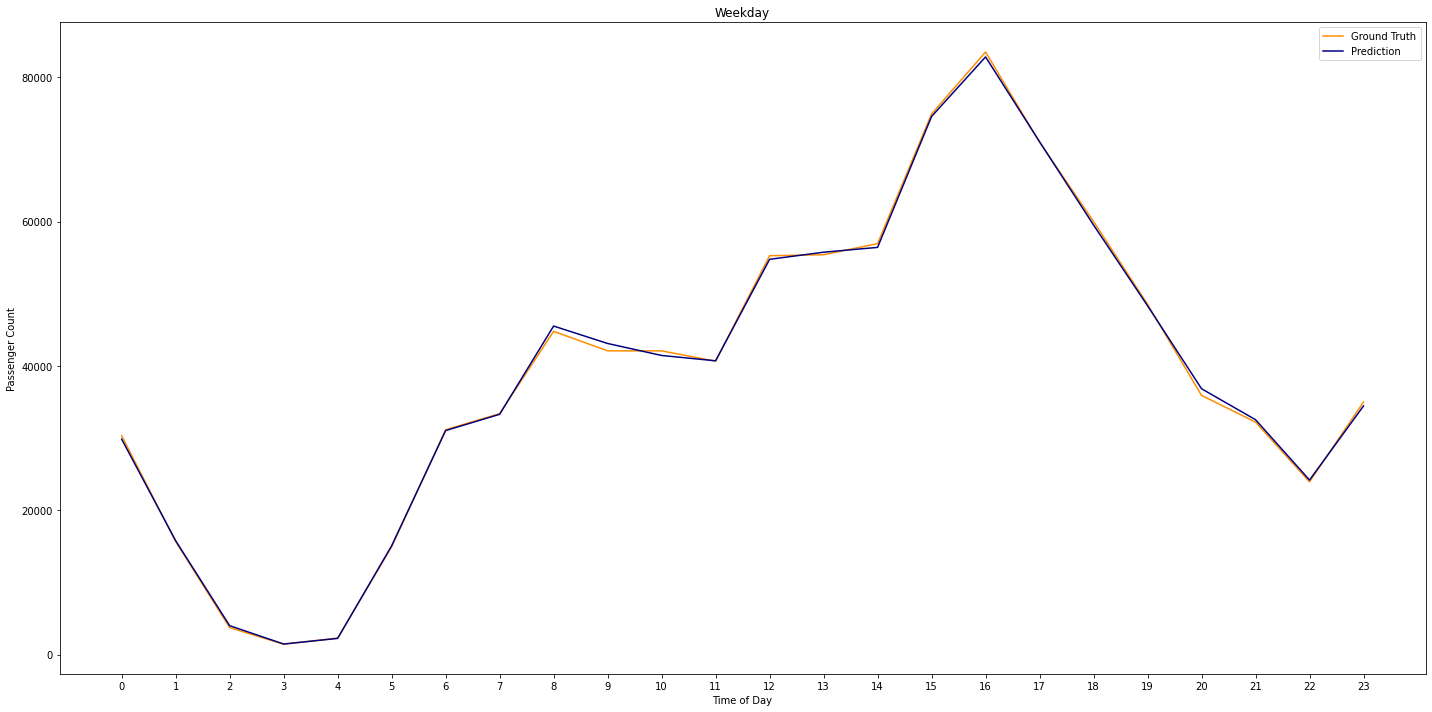

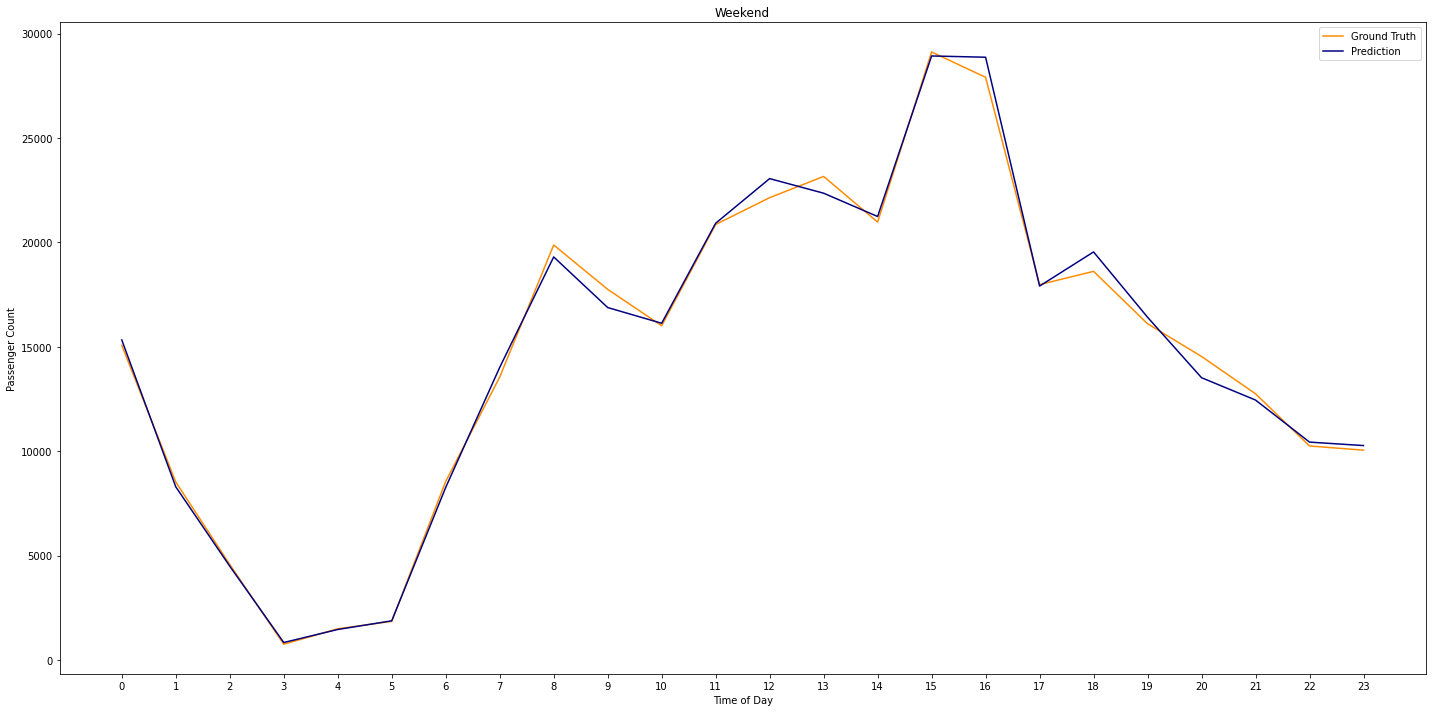

In [19]:
# note: plot_passenger_count_by_time_of_day will only ever return non-null values for fig_weekday and fig_weekend;
# fig_datetime included for consistency with gt_pred_scatter API
fig_weekday, fig_weekend, fig_datetime = experiment_eval.plot_passenger_count_by_time_of_day('train', segment=None, agg='sum')

## Mean predicted vs. ground truth passenger count by hour of day (whole route)

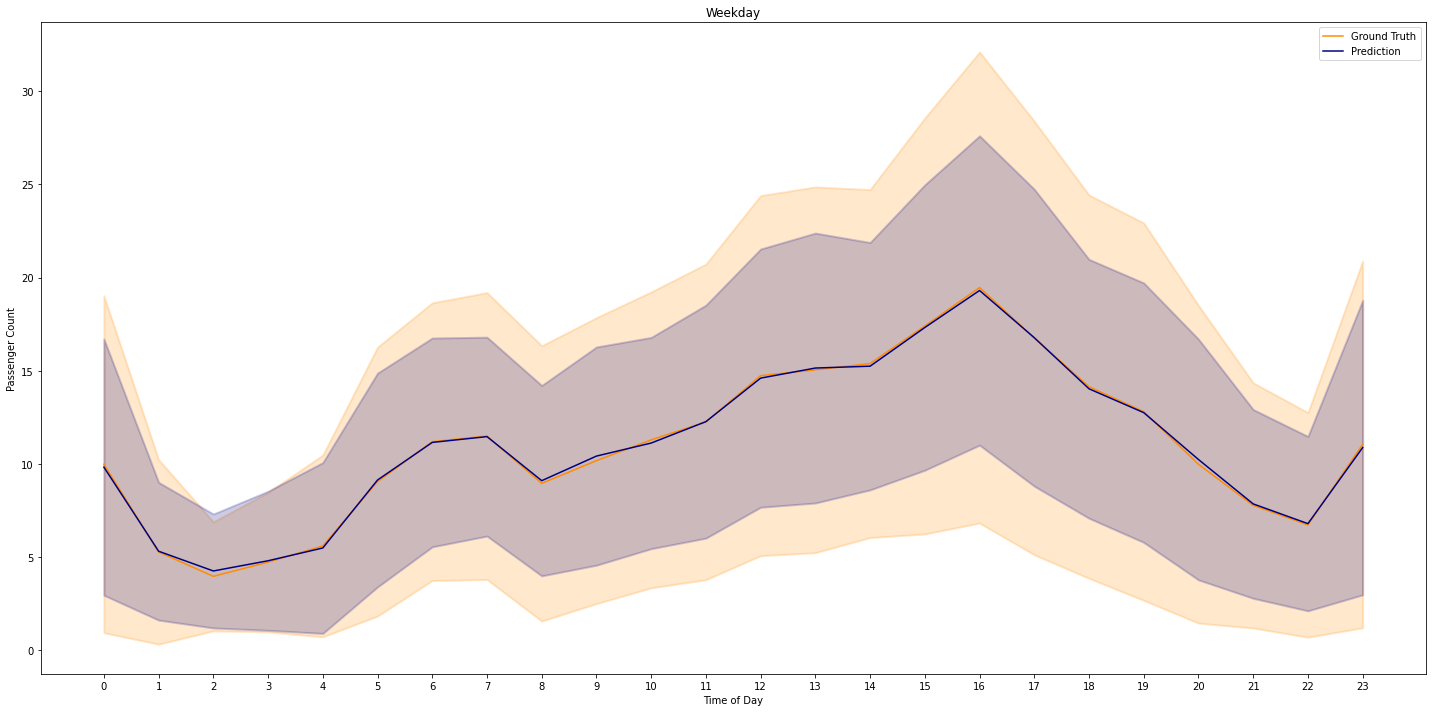

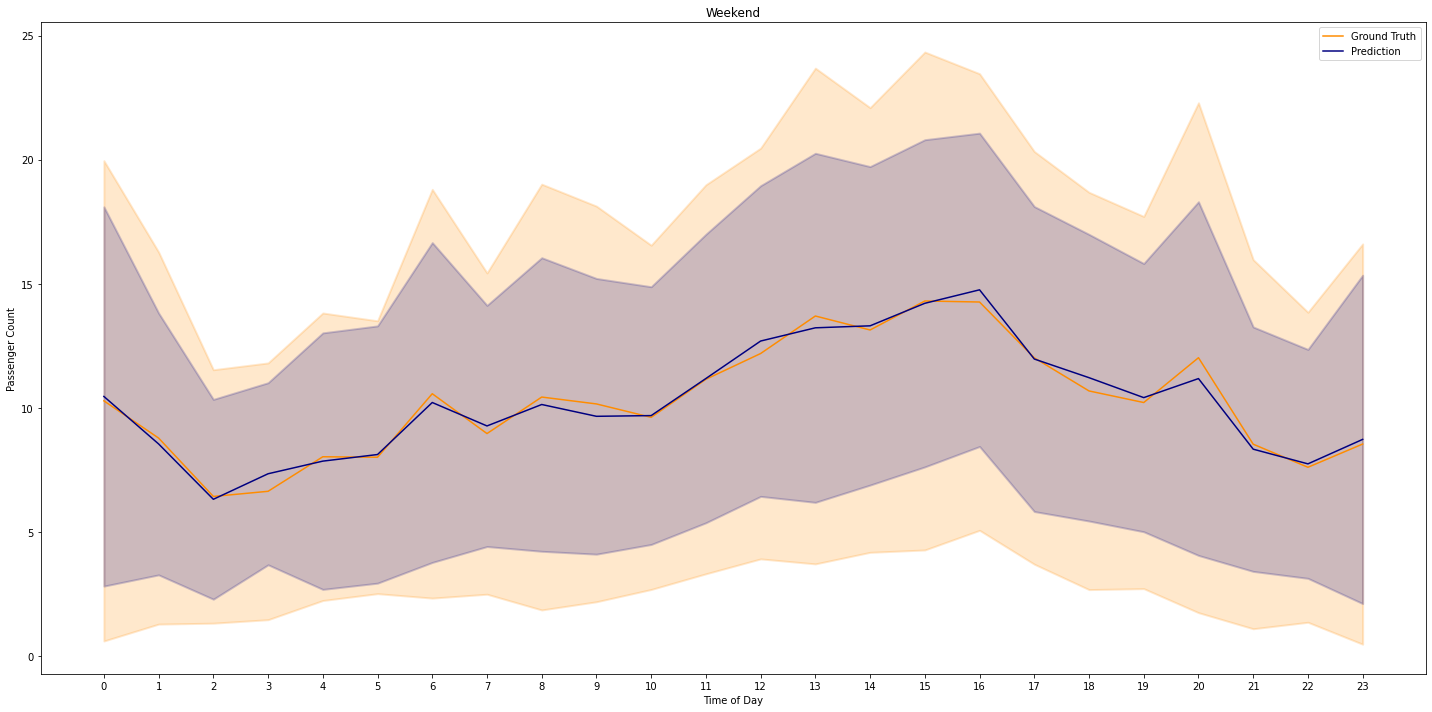

In [17]:
fig_weekday, fig_weekend, fig_datetime = experiment_eval.plot_passenger_count_by_time_of_day('train', segment=None, agg='mean')

## Total predicted vs. ground truth passenger count by hour of day (single stop)

MTA_303673


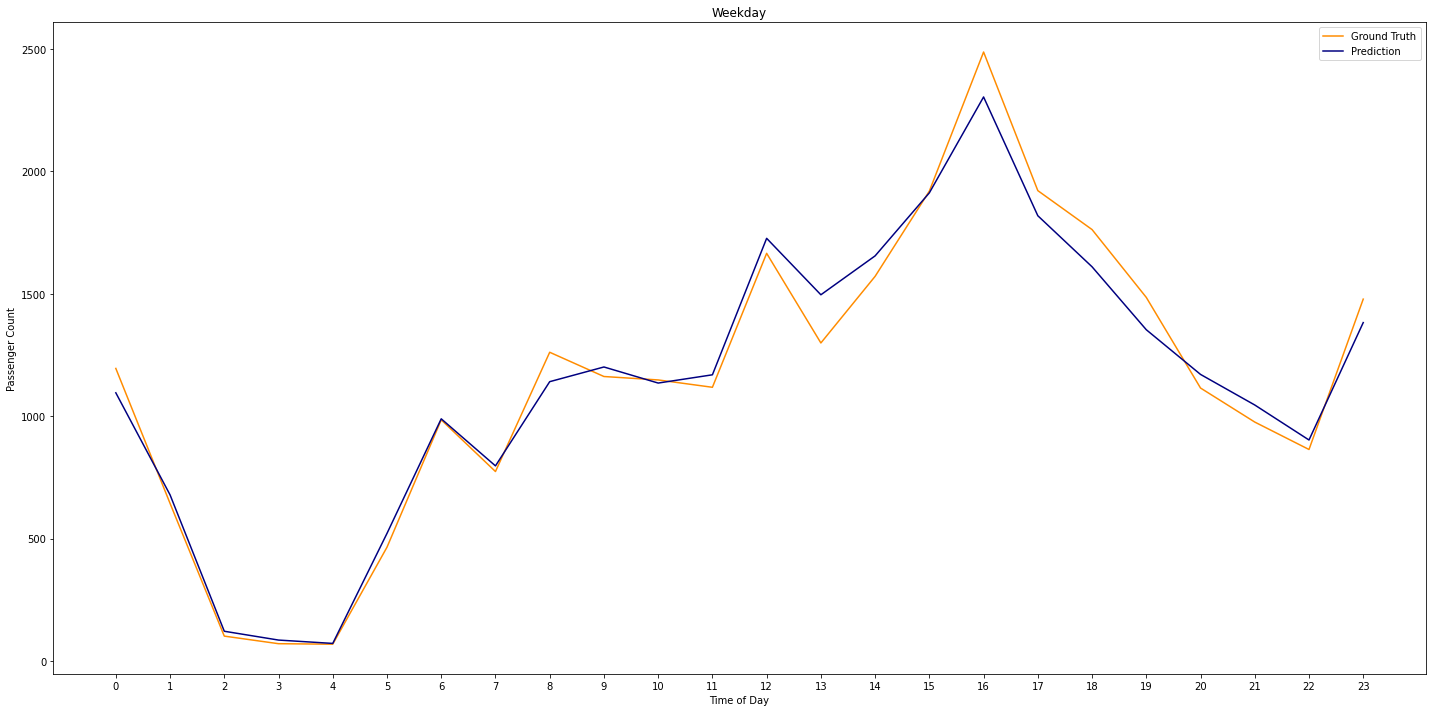

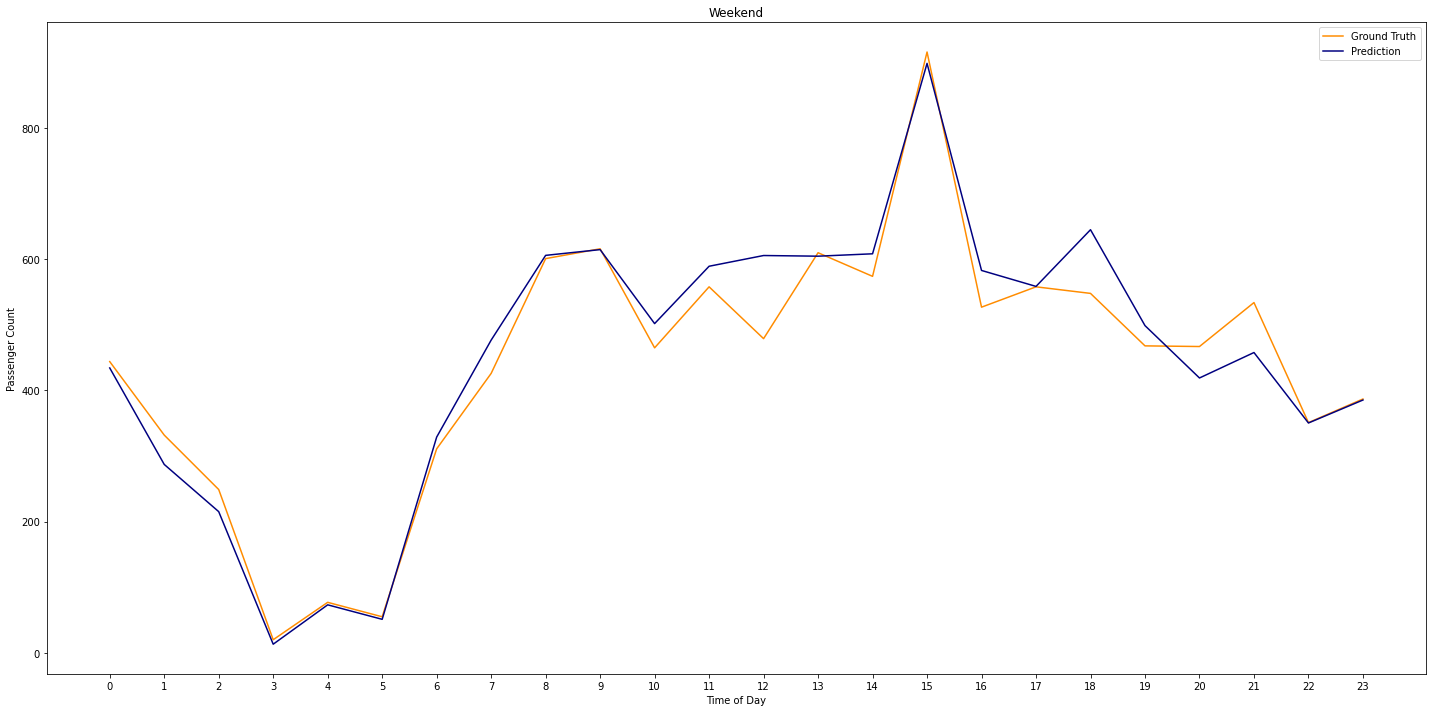

In [40]:
stop_pos = 20
stop_id = experiment_eval.stop_pos2stop_id[stop_pos]
print(stop_id)

# note: segment parameter needs to correspond to stop position int
fig_weekday, fig_weekend, fig_datetime = experiment_eval.plot_passenger_count_by_time_of_day('train', segment=stop_pos, agg='sum')

## Mean predicted vs. ground truth passenger count by hour of day (single stop)

MTA_303663


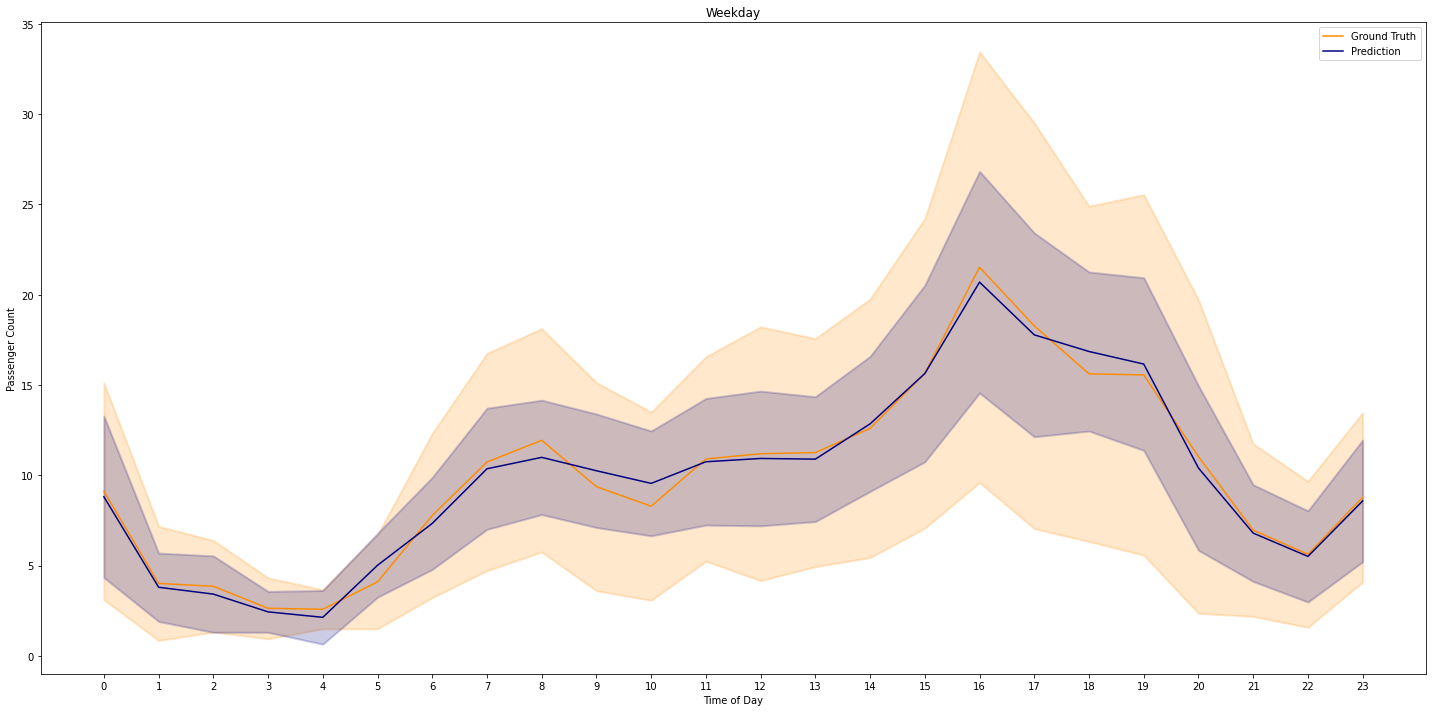

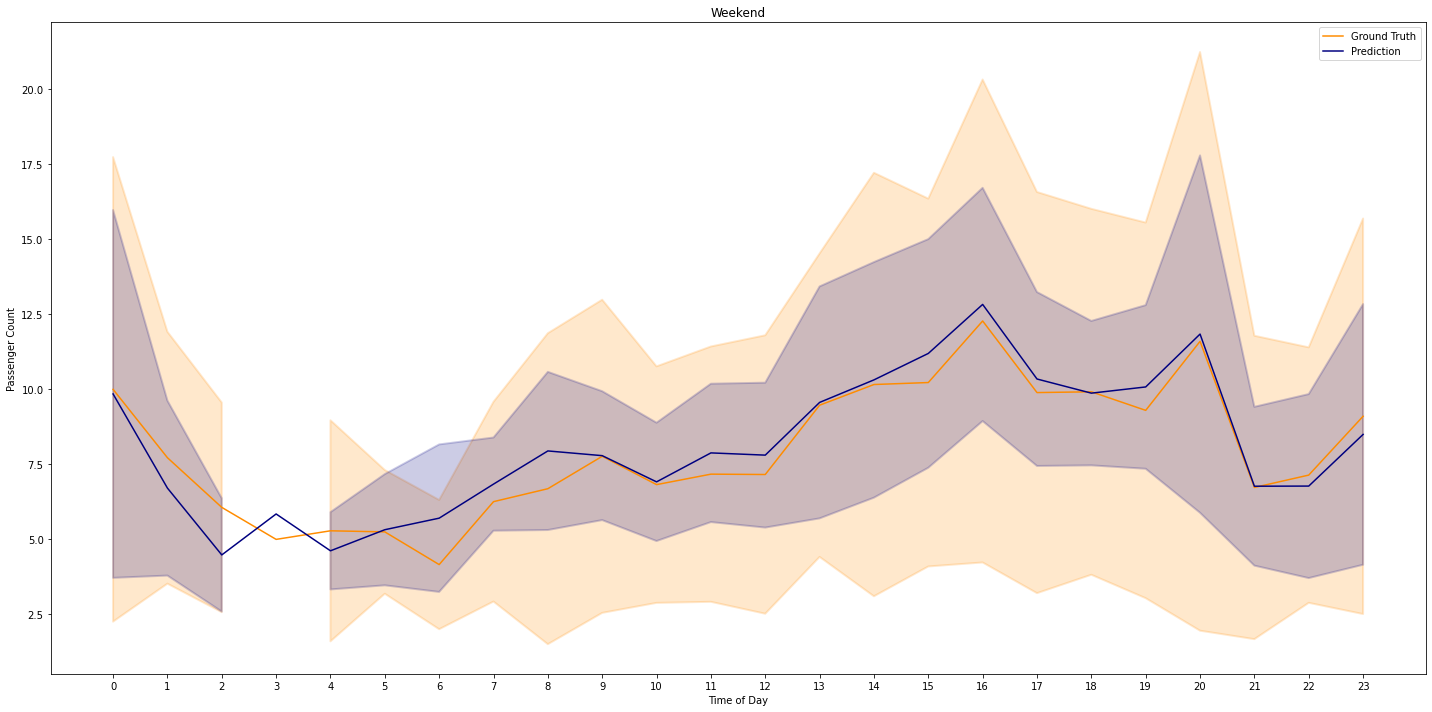

In [41]:
stop_pos = 12
stop_id = experiment_eval.stop_pos2stop_id[stop_pos]
print(stop_id)

# note: segment parameter needs to correspond to stop position int
fig_weekday, fig_weekend, fig_datetime = experiment_eval.plot_passenger_count_by_time_of_day('train', segment=stop_pos, agg='mean')

## Prediction vs. ground truth scatter plots:

### Simple (all errors)

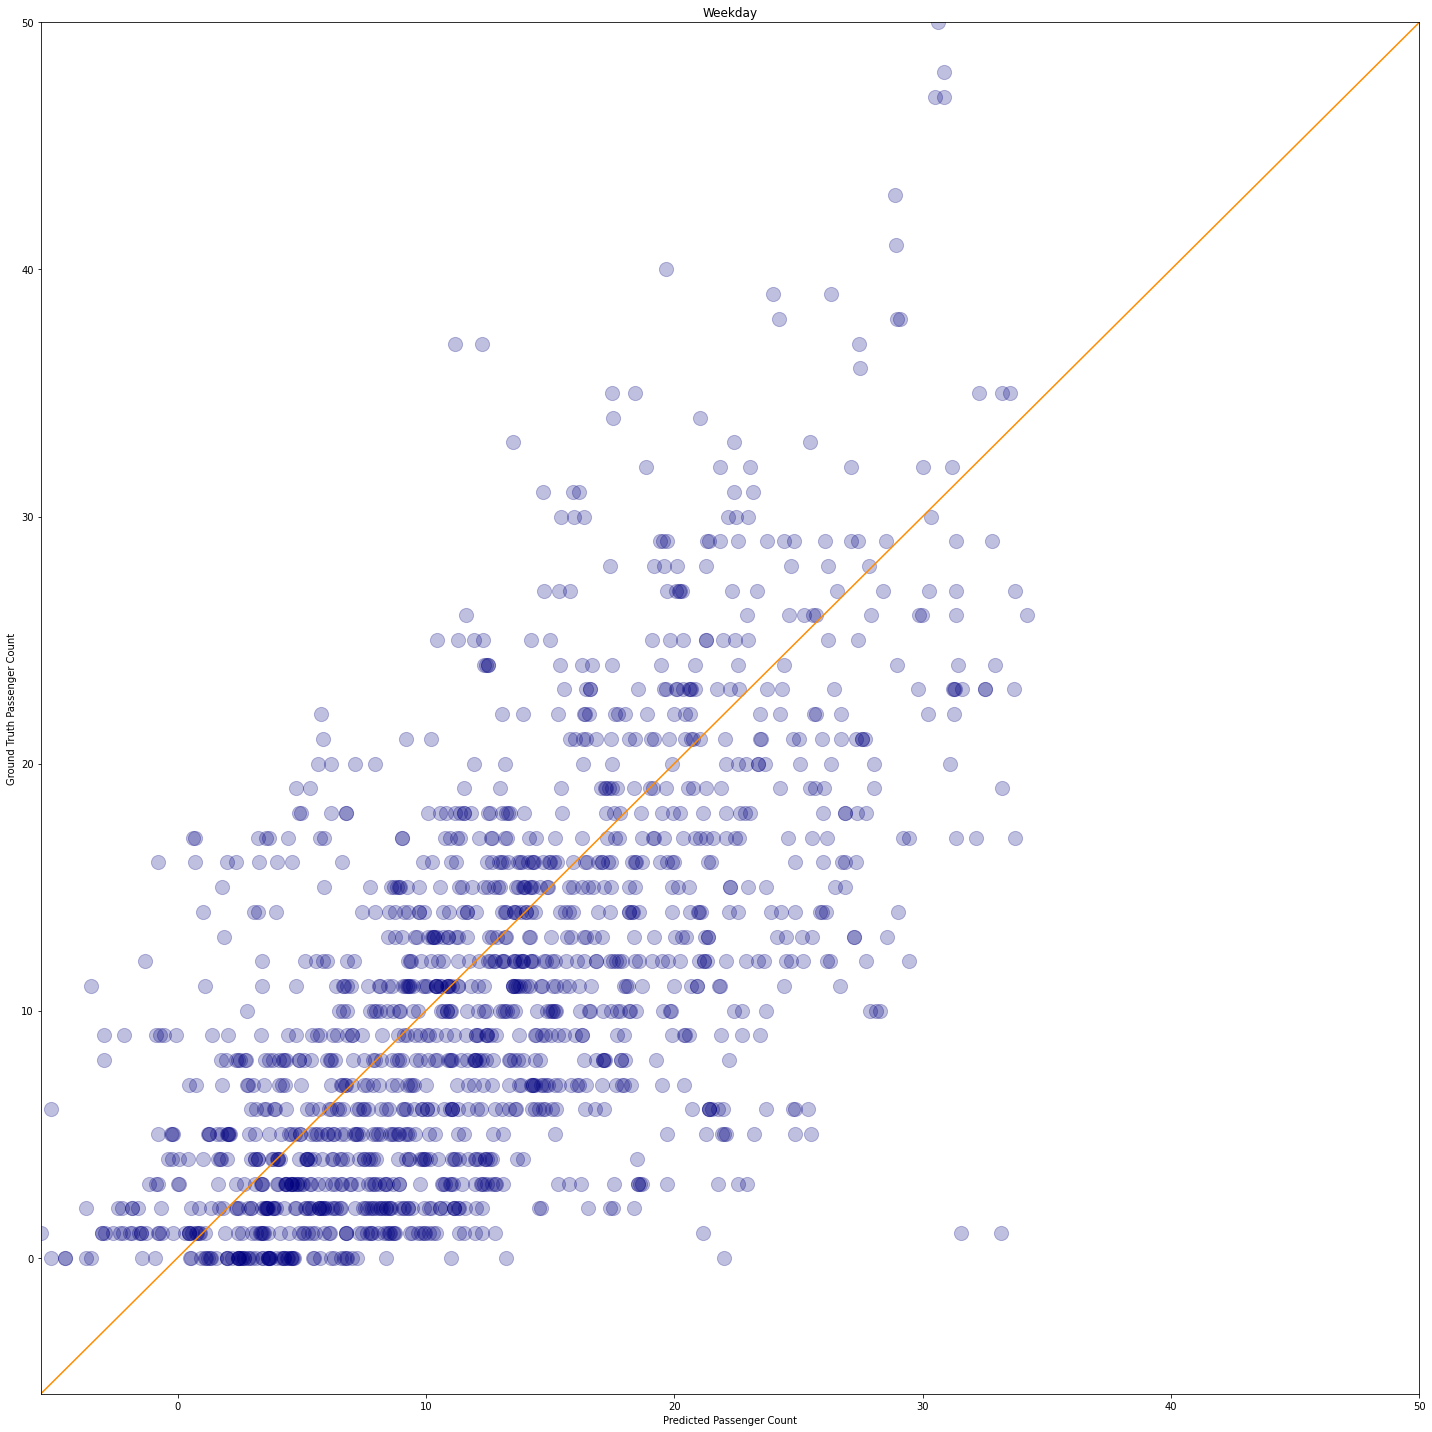

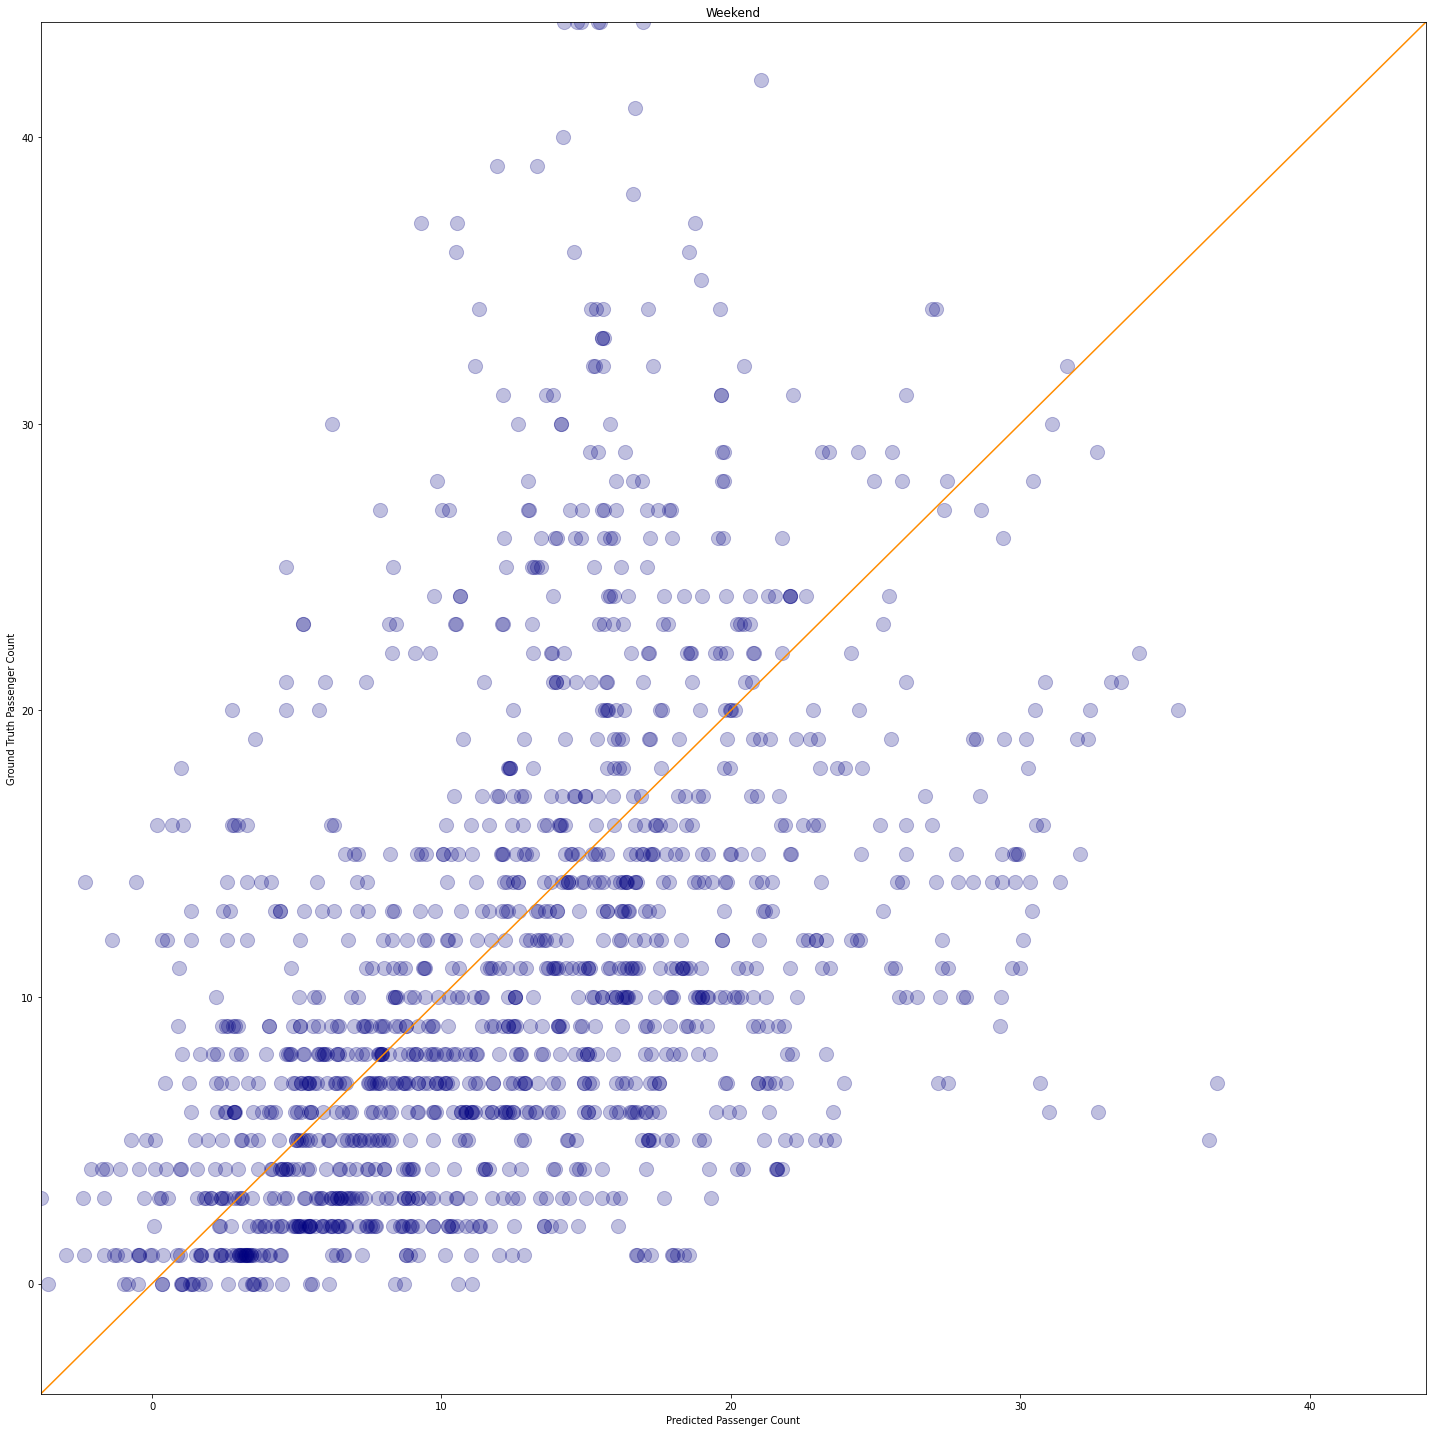

In [50]:
# note: parameter gt_y not needed when plot='simple';
#       parameter n not needed errors='all'
fig_weekday, fig_weekend, fig_datetime = experiment_eval.gt_pred_scatter('test', plot='simple', errors='all', n=100, s=200, gt_y=True)

### By stop - 500 largest errors; predictions plotted in relation to ground truth (i.e. gt_y=True)

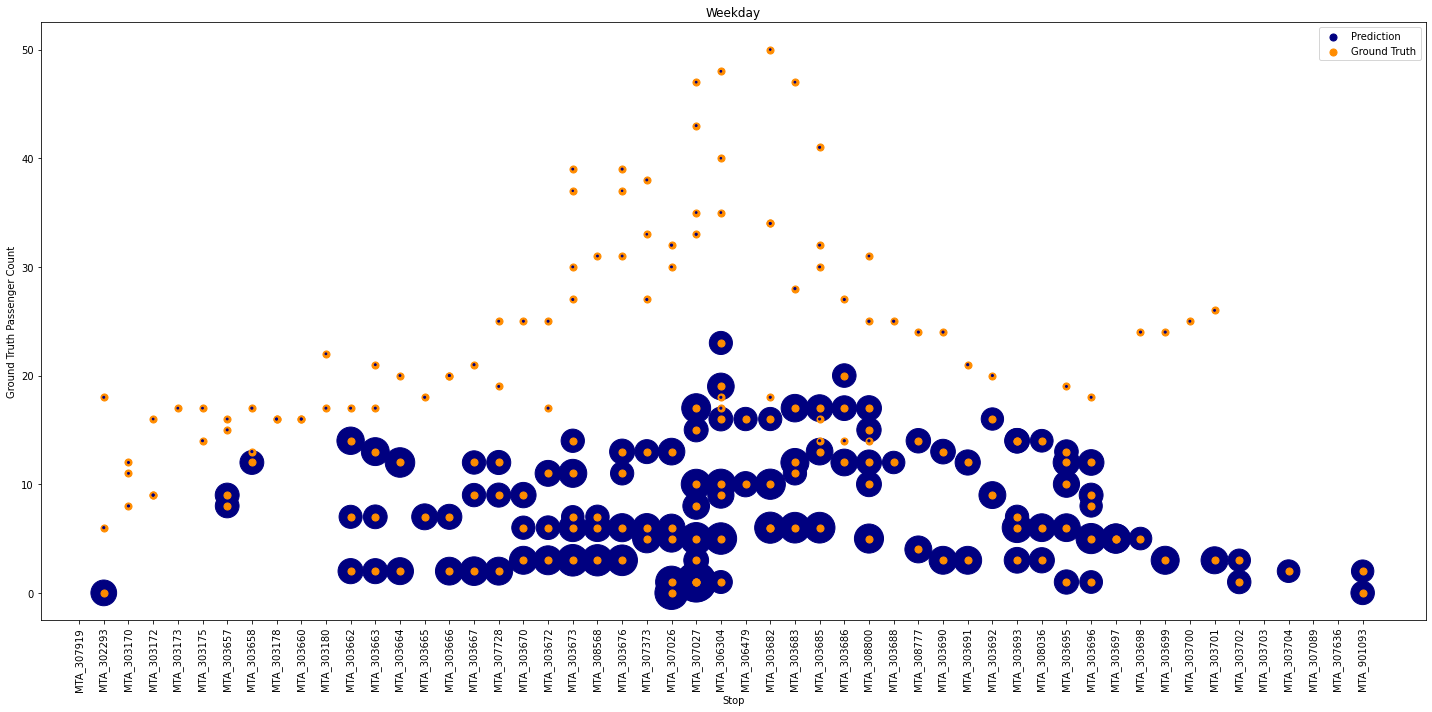

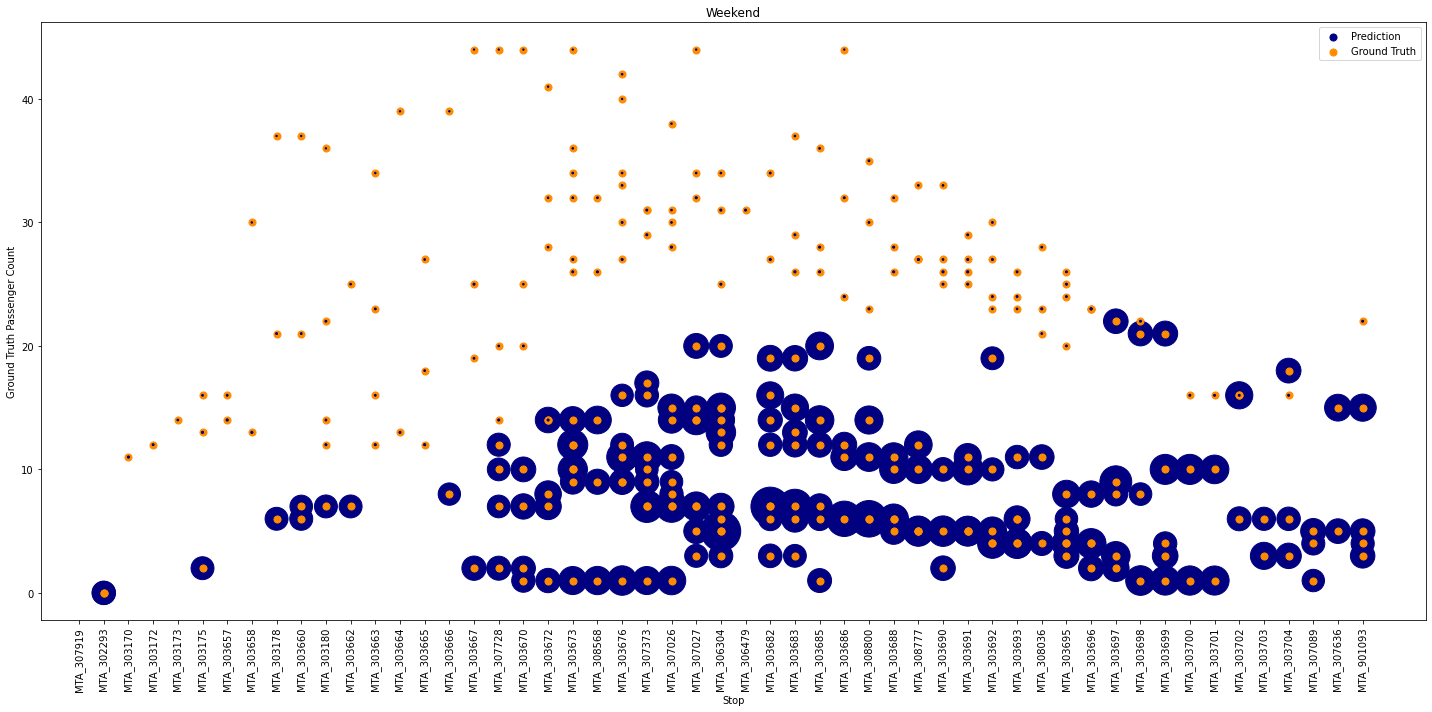

In [53]:
fig_weekday, fig_weekend, fig_datetime = experiment_eval.gt_pred_scatter('test', plot='stop', errors='large', n=500, s=50, gt_y=True)

### By stop - 500 largest errors; ground truth plotted in relation to predictions (i.e. gt_y=False)

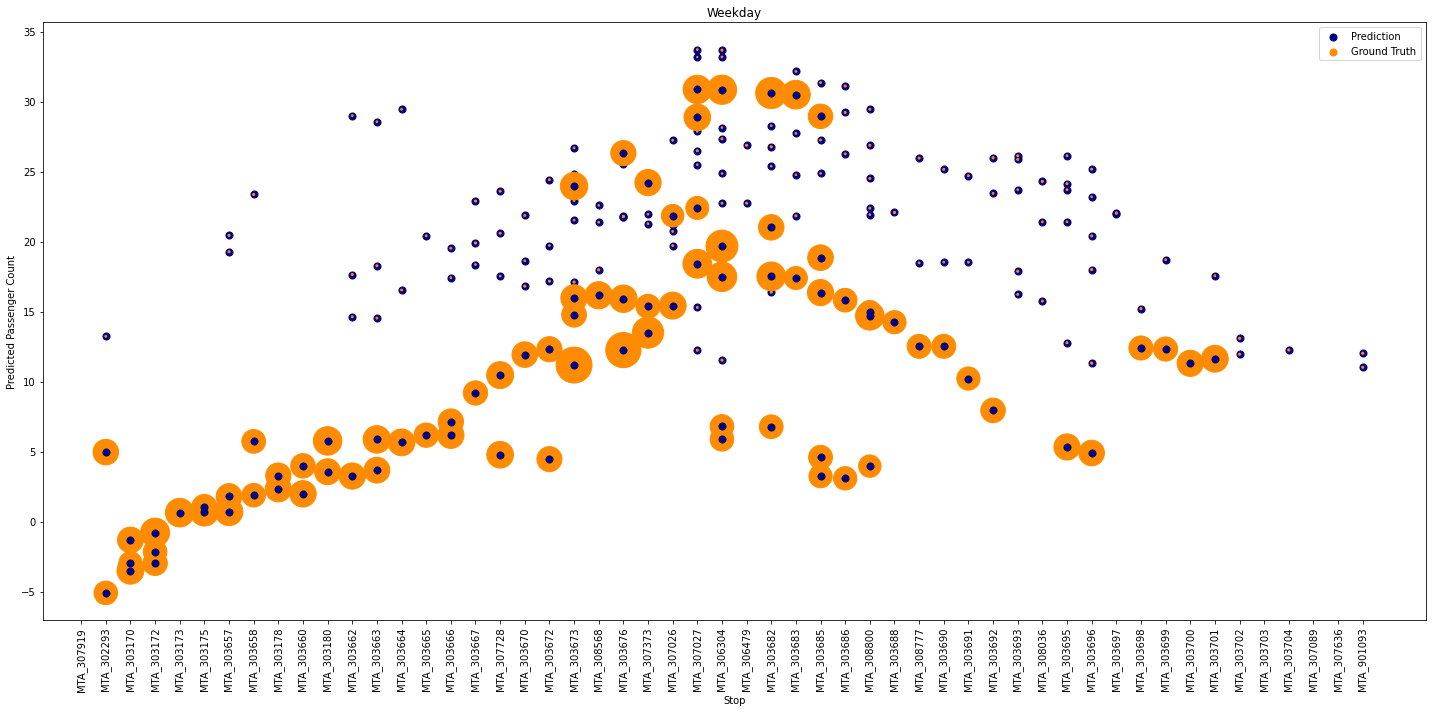

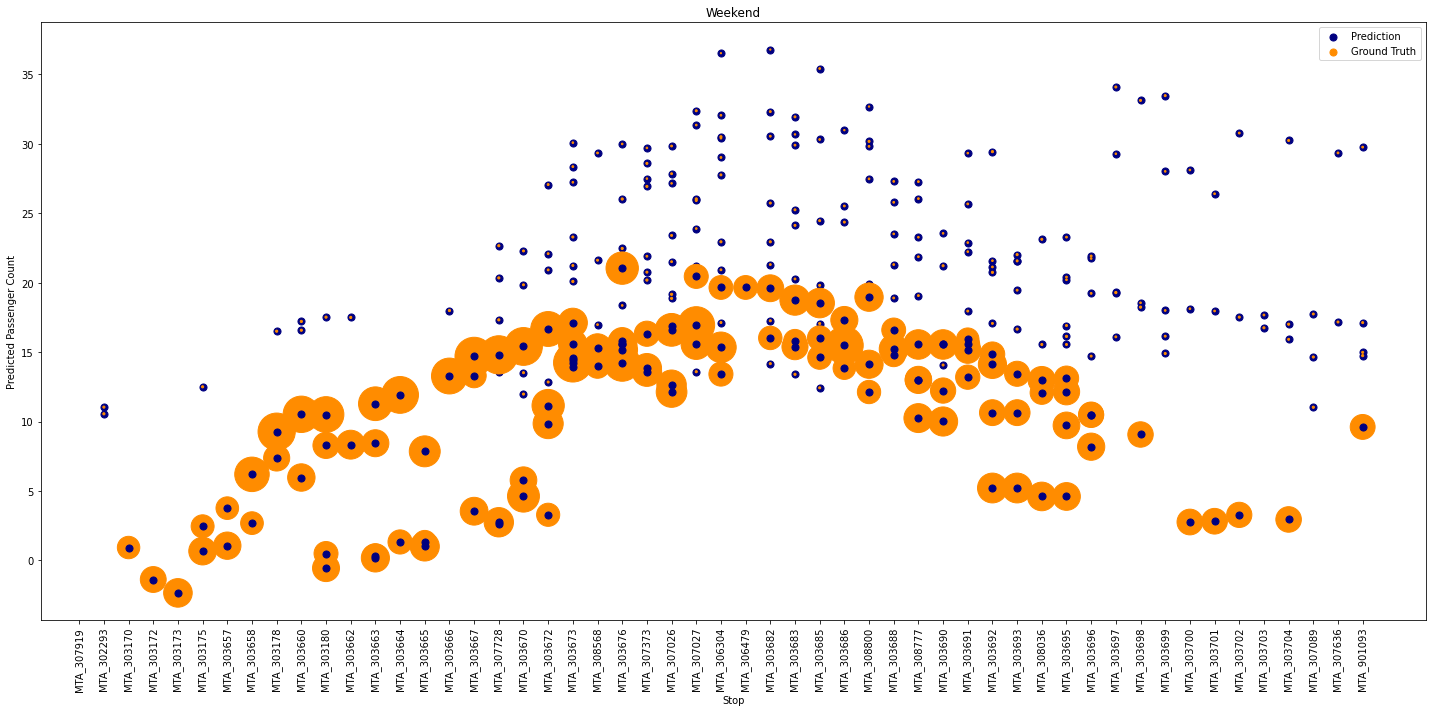

In [55]:
# note: plotting ground truth in relation to predictions tends to result in more visible markers since two observations close together in
# time that have the same ground truth passenger_count will appear as basically the same datapoint in the above plot. in the below chart,
# however, since the predicted passenger_count for these two observations tends to vary, they will appear as two datapoints 
fig_weekday, fig_weekend, fig_datetime = experiment_eval.gt_pred_scatter('test', plot='stop', errors='large', n=500, s=50, gt_y=False)

### By hour - 500 smallest errors; predictions plotted in relation to ground truth (i.e. gt_y=True)

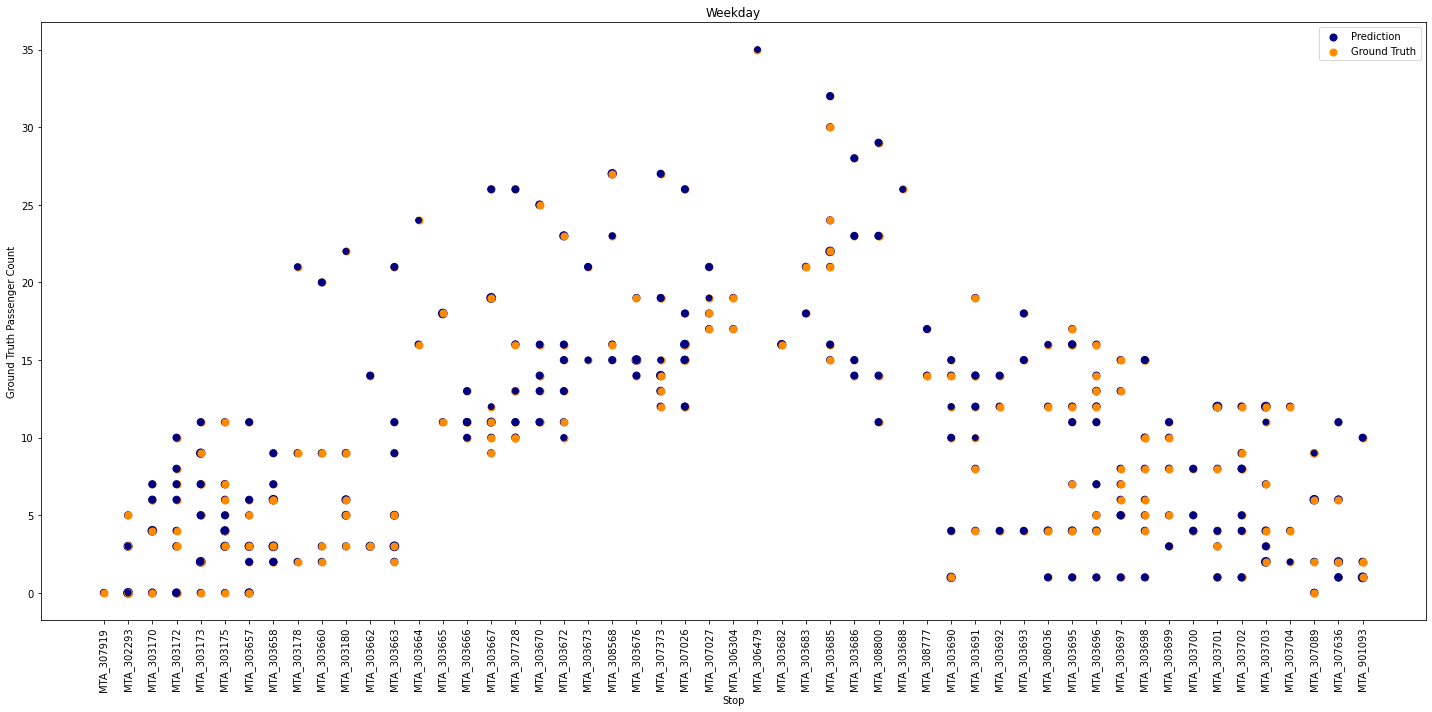

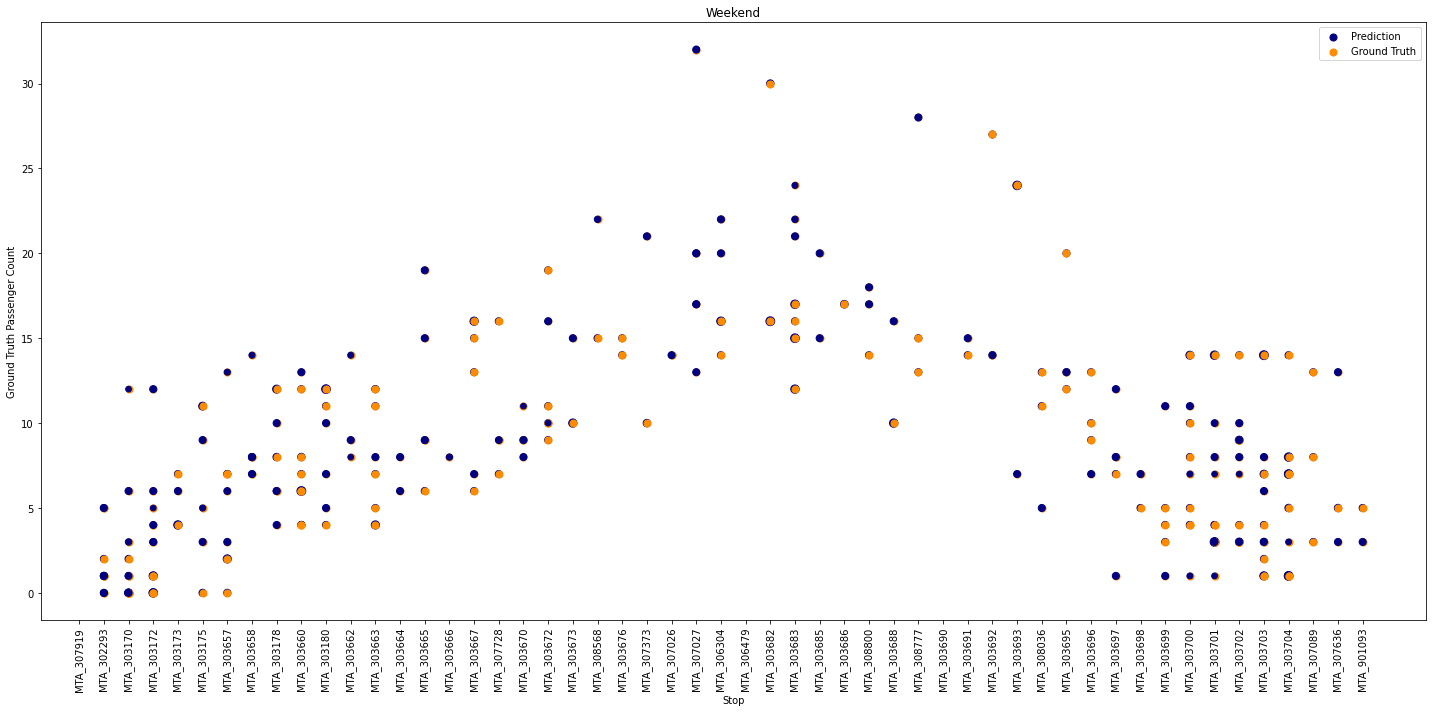

In [57]:
fig_weekday, fig_weekend, fig_datetime = experiment_eval.gt_pred_scatter('test', plot='stop', errors='small', n=500, s=50, gt_y=True)

### By datetime - 500 largest errors; predictions plotted in relation to ground truth (i.e. gt_y=True)

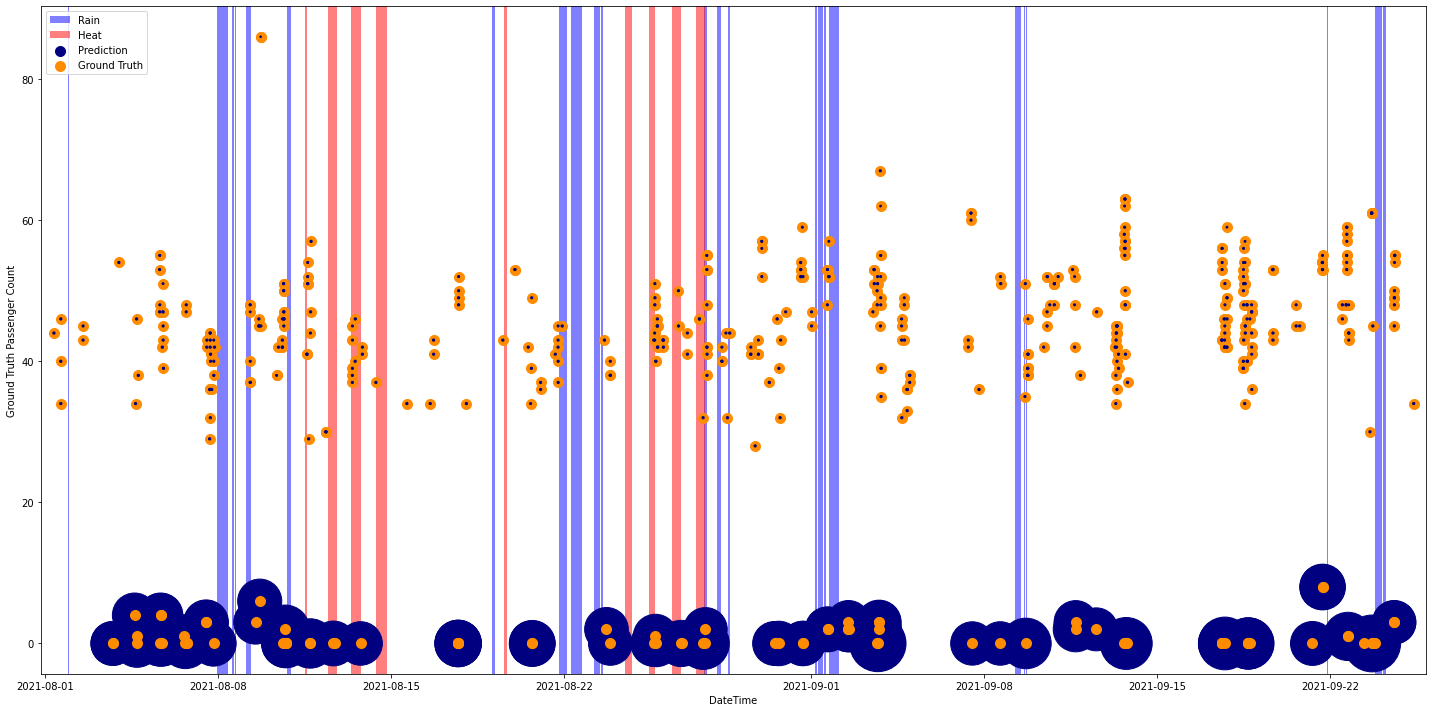

In [60]:
# note: switched back to train set here since the particular testing dates we looked at in our partition did not include any weather events
fig_weekday, fig_weekend, fig_datetime = experiment_eval.gt_pred_scatter('train', plot='datetime', errors='large', n=500, s=100, gt_y=True)